<a href="https://colab.research.google.com/github/cpalme28/Pitching-Analysis/blob/main/Pitcher_Optimization_Zac_Gallen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [67]:
!pip install pybaseball

In [68]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

from pybaseball import statcast_pitcher, playerid_lookup

Use data from Zac Gallen in the 2023 season.

In [69]:
# select player
gallen = playerid_lookup('Gallen', 'Zac')
print(gallen)

  name_last name_first  key_mlbam key_retro  key_bbref  key_fangraphs  \
0    gallen        zac     668678  gallz001  galleza01          19291   

   mlb_played_first  mlb_played_last  
0            2019.0           2025.0  


In [70]:
gallen_id = gallen['key_mlbam'].values[0] # pull out zac gallen's mlb id

# get data for 2023 season
data = statcast_pitcher('2023-03-30', '2023-10-01', gallen_id)
data.head()

Gathering Player Data


,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle,attack_angle,attack_direction,swing_path_tilt,intercept_ball_minus_batter_pos_x_inches,intercept_ball_minus_batter_pos_y_inches
0,FF,2023-09-29,93.7,-2.73,5.93,"Gallen, Zac",665161,668678,field_out,hit_into_play,...,1.0,1.24,0.20,0.20,45.1,7.932988,-4.727326,39.873903,30.909913,21.288889
1,FF,2023-09-29,93.8,-2.56,5.95,"Gallen, Zac",665161,668678,NaN,foul,...,1.0,1.10,0.09,0.09,45.8,13.056423,-1.877408,31.915862,38.440832,22.718369
2,FF,2023-09-29,93.8,-2.79,5.87,"Gallen, Zac",665161,668678,NaN,ball,...,1.0,1.15,0.21,0.21,43.7,NaN,NaN,NaN,NaN,NaN
3,FF,2023-09-29,93.6,-2.71,5.91,"Gallen, Zac",665161,668678,NaN,ball,...,1.0,1.26,0.03,0.03,47.7,NaN,NaN,NaN,NaN,NaN
4,FF,2023-09-29,91.7,-2.82,5.96,"Gallen, Zac",676801,668678,single,hit_into_play,...,1.0,1.39,0.26,0.26,44.2,19.757869,0.555497,38.077544,37.549808,26.890240


In [71]:
cols = ['pitch_type', 'game_date','release_speed', 'type', 'zone', 'stand', 'balls', 'strikes', 'outs_when_up', 'inning', 'effective_speed']
df = data[cols].copy()

From documentation:
* pitch_type
  * FF: four-seam fastball
  * KC: knuckle-curve
  * CH: change-up
  * FC: cutter
  * SL: slider
  * SI: sinker
* type
  * B: ball
  * S: strike
  * X: in play
* zone
  * saved image
* stand
  * R: batter is rightie
  * L: batter is leftie
* effective_speed
  * derived speed based on the extension of the pitcher's release

In [72]:
df['count'] = df['balls'].astype(str) + '-' + df['strikes'].astype(str) # put balls and strikes columns into one column called count
#df = df.drop(['balls', 'strikes'], axis=1) # remove balls and strikes column
df.head()

,pitch_type,game_date,release_speed,type,zone,stand,balls,strikes,outs_when_up,inning,effective_speed,count
0,FF,2023-09-29,93.7,X,7,R,2,1,0,7,94.5,2-1
1,FF,2023-09-29,93.8,S,2,R,2,0,0,7,94.7,2-0
2,FF,2023-09-29,93.8,B,11,R,1,0,0,7,94.4,1-0
3,FF,2023-09-29,93.6,B,11,R,0,0,0,7,94.5,0-0
4,FF,2023-09-29,91.7,X,4,R,1,2,0,7,92.2,1-2


In [73]:
df['pitch_type'].value_counts()

,count
pitch_type,
FF,1614
KC,736
CH,453
FC,298
SL,146
SI,1


In [74]:
bins = [0, 80, 85, 90, 95, 100, 105]
labels = ['< 80', '80 - 85', '85 - 90', '90 - 95', '95 - 100', '100+']

df['speed_bucket'] = pd.cut(df['release_speed'], bins=bins, labels=labels, right=False)

speed_pitch_table = df.groupby(['speed_bucket', 'pitch_type'], observed=True).size().unstack(fill_value=0)

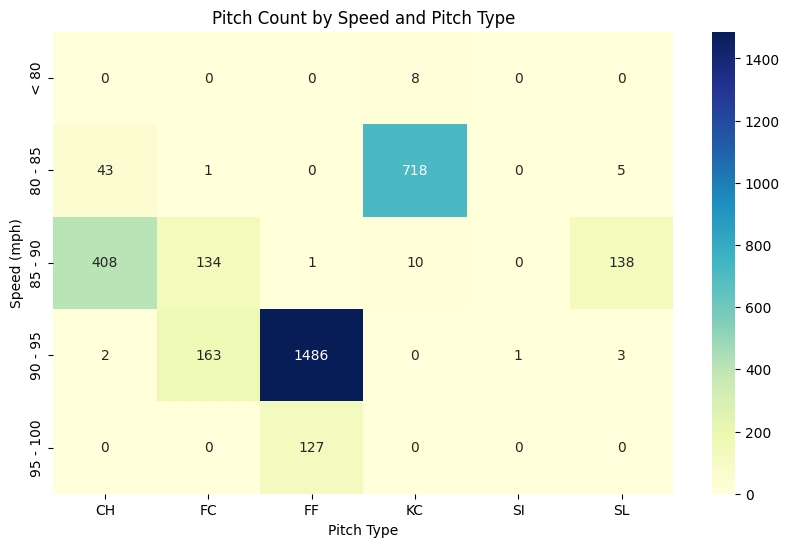

In [75]:
plt.figure(figsize=(10,6))
sns.heatmap(speed_pitch_table, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Pitch Count by Speed and Pitch Type')
plt.xlabel('Pitch Type')
plt.ylabel('Speed (mph)')
plt.show()

In [76]:
df['type'].value_counts()

,count
type,
S,1520
B,1154
X,574


In [77]:
pd.crosstab(df['pitch_type'], df['type'])

type,B,S,X
pitch_type,,,
CH,170,195,88
FC,124,112,62
FF,497,829,288
KC,303,324,109
SI,0,1,0
SL,60,59,27


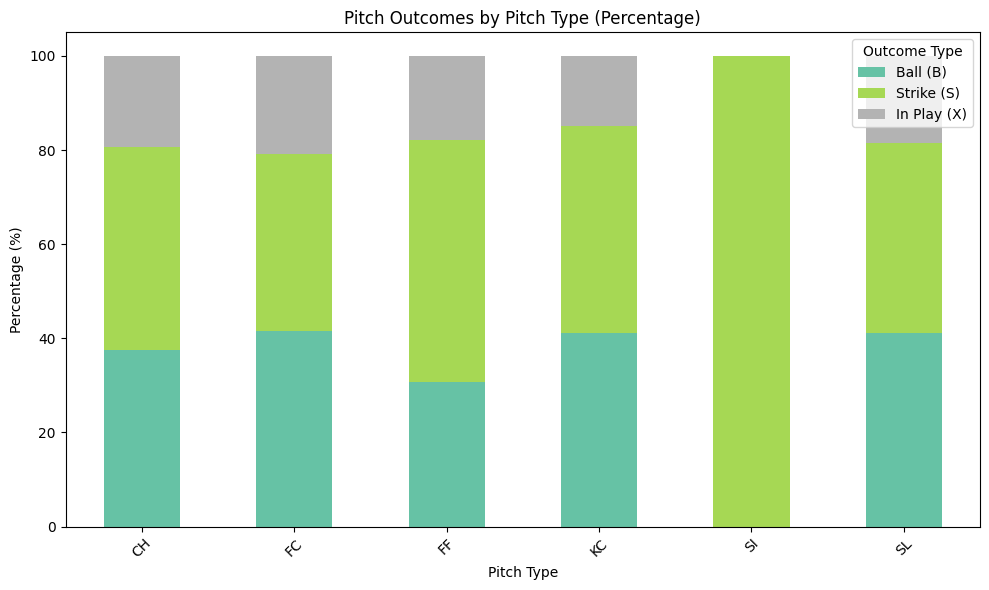

In [78]:
pitch_type_counts = df.groupby(['pitch_type', 'type']).size().unstack(fill_value=0)

pitch_type_pct = pitch_type_counts.div(pitch_type_counts.sum(axis=1), axis=0) * 100

pitch_type_pct.plot(
    kind='bar',
    stacked=True,
    figsize=(10, 6),
    colormap='Set2'
)

plt.title('Pitch Outcomes by Pitch Type (Percentage)')
plt.xlabel('Pitch Type')
plt.ylabel('Percentage (%)')
plt.legend(title='Outcome Type', labels=['Ball (B)', 'Strike (S)', 'In Play (X)'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Note:** there is only one SI pitch recorded during the 2023 season for Zac Gallen



In [80]:
pd.crosstab(df['pitch_type'], df['count'])

count,0-0,0-1,0-2,1-0,1-1,1-2,2-0,2-1,2-2,3-0,3-1,3-2
pitch_type,,,,,,,,,,,,
CH,40,73,19,59,74,46,14,36,63,1,5,23
FC,97,64,10,25,34,16,5,24,14,0,3,6
FF,503,206,94,147,143,118,54,76,117,20,35,101
KC,174,90,84,47,71,129,15,22,71,0,10,23
SI,1,0,0,0,0,0,0,0,0,0,0,0
SL,32,19,16,10,14,20,3,8,16,0,2,6


In [81]:
zone_chart = np.zeros((8,8))

zone_mapping = {
    11: [(0,0),(0,1),(0,2),(0,3),(1,0),(2,0),(3,0)],
    12: [(0,4),(0,5),(0,6),(0,7),(1,7),(2,7),(3,7)],
    13: [(4,0),(5,0),(6,0),(7,0),(7,1),(7,2),(7,3)],
    14: [(4,7),(5,7),(6,7),(7,7),(7,4),(7,5),(7,6)],
    1: [(1,1),(1,2),(2,1),(2,2)],
    2: [(1,3),(1,4),(2,3),(2,4)],
    3: [(1,5),(1,6),(2,5),(2,6)],
    4: [(3,1),(3,2),(4,1),(4,2)],
    5: [(3,3),(3,4),(4,3),(4,4)],
    6: [(3,5),(3,6),(4,5),(4,6)],
    7: [(5,1),(5,2),(6,1),(6,2)],
    8: [(5,3),(5,4),(6,3),(6,4)],
    9: [(5,5),(5,6),(6,5),(6,6)]
}

In [82]:
zone_counts = df['zone'].value_counts().to_dict()

In [87]:
for zone, coords in zone_mapping.items():
  count = zone_counts.get(zone, 0)
  for r, c in coords:
    zone_chart[r, c] = count

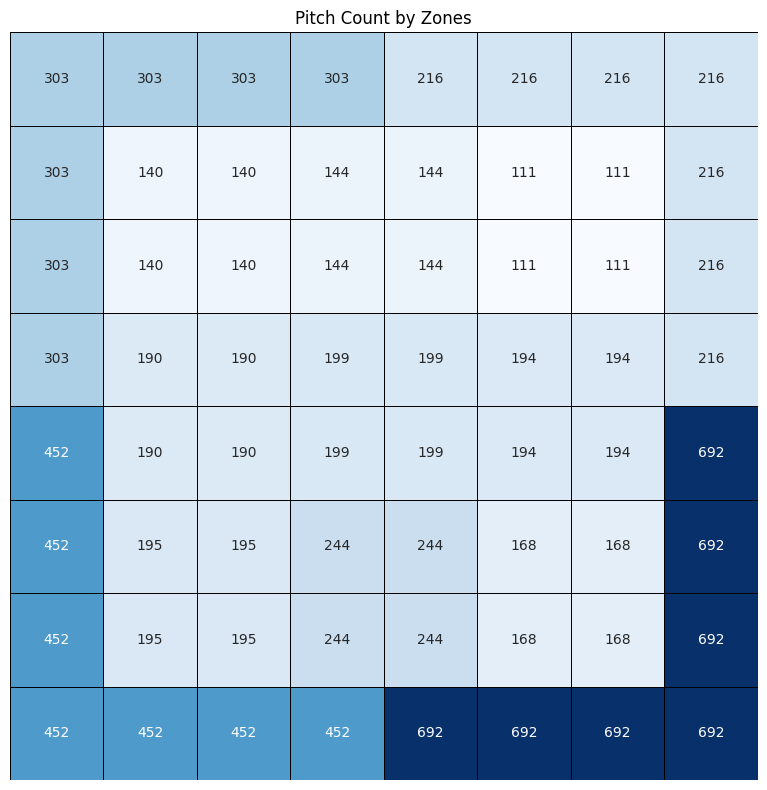

Legend
[[11 11 11 11 12 12 12 12]
 [11  1  1  2  2  3  3 12]
 [11  1  1  2  2  3  3 12]
 [11  4  4  5  5  6  6 12]
 [13  4  4  5  5  6  6 14]
 [13  7  7  8  8  9  9 14]
 [13  7  7  8  8  9  9 14]
 [13 13 13 13 14 14 14 14]]


In [88]:
# Plot heatmap
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(
    zone_chart,
    annot=True,
    fmt='.0f',
    cmap='Blues',
    cbar=False,
    square=True,
    linewidths=0.5,
    linecolor='black',
    xticklabels=False,
    yticklabels=False,
    ax=ax
)
ax.set_title("Pitch Count by Zones")
#ax.invert_yaxis()

plt.tight_layout()
plt.show()

# print zone legend
zone_legend = np.array([
    [11, 11, 11, 11, 12, 12, 12, 12],
    [11, 1, 1, 2, 2, 3, 3, 12],
    [11, 1, 1, 2, 2, 3, 3, 12],
    [11, 4, 4, 5, 5, 6, 6, 12],
    [13, 4, 4, 5, 5, 6, 6, 14],
    [13, 7, 7, 8, 8, 9, 9, 14],
    [13, 7, 7, 8, 8, 9, 9, 14],
    [13, 13, 13, 13, 14, 14, 14, 14]
])
print("Legend")
print(zone_legend)


In [89]:
df['game_date'].unique()

array(['2023-09-29', '2023-09-24', '2023-09-19', '2023-09-13',
       '2023-09-08', '2023-09-03', '2023-08-28', '2023-08-22',
       '2023-08-17', '2023-08-12', '2023-08-06', '2023-08-01',
       '2023-07-26', '2023-07-20', '2023-07-15', '2023-07-07',
       '2023-07-02', '2023-06-27', '2023-06-21', '2023-06-16',
       '2023-06-11', '2023-06-04', '2023-05-30', '2023-05-24',
       '2023-05-19', '2023-05-13', '2023-05-08', '2023-05-02',
       '2023-04-26', '2023-04-21', '2023-04-16', '2023-04-10',
       '2023-04-04', '2023-03-30'], dtype=object)

In [93]:
games = dict(tuple(df.groupby('game_date')))

games['2023-09-24']

,pitch_type,game_date,release_speed,type,zone,stand,balls,strikes,outs_when_up,inning,effective_speed,count,speed_bucket
104,KC,2023-09-24,82.2,X,1,R,0,0,2,6,82.4,0-0,80 - 85
105,KC,2023-09-24,81.8,X,13,L,0,1,1,6,82.7,0-1,80 - 85
106,FF,2023-09-24,92.7,S,5,L,0,0,1,6,93.3,0-0,90 - 95
107,KC,2023-09-24,81.7,X,7,R,1,1,0,6,82.7,1-1,80 - 85
108,FC,2023-09-24,89.2,B,14,R,0,1,0,6,90.0,0-1,85 - 90
...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,FC,2023-09-24,89.5,B,14,R,1,2,0,1,89.9,1-2,85 - 90
191,FF,2023-09-24,92.8,S,4,R,1,2,0,1,92.7,1-2,90 - 95
192,FF,2023-09-24,93.6,S,8,R,1,1,0,1,93.8,1-1,90 - 95
193,FF,2023-09-24,92.5,S,4,R,1,0,0,1,92.5,1-0,90 - 95


In [96]:
pitch_counts = df.groupby(['game_date', 'inning']).size()

print(pitch_counts)

game_date   inning
2023-03-30  1         13
            2         11
            3         27
            4         13
            5         25
                      ..
2023-09-29  3         12
            4          9
            5         10
            6         27
            7          9
Length: 217, dtype: int64


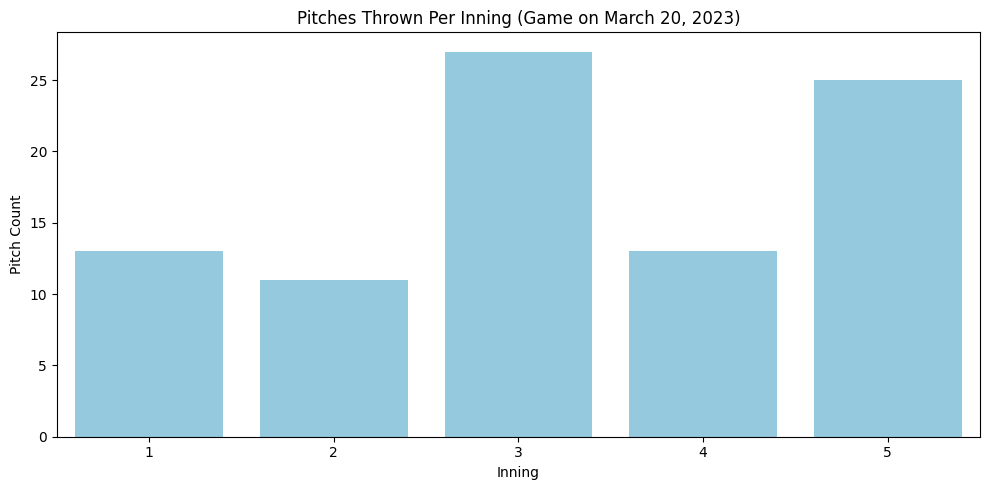

In [100]:
game_df = df[df['game_date'] == '2023-03-30']
pitch_counts1 = game_df.groupby('inning').size().reset_index(name='pitch_count')

plt.figure(figsize=(10,5))
sns.barplot(data=pitch_counts1, x='inning', y='pitch_count', color='skyblue')
plt.title('Pitches Thrown Per Inning (Game on March 20, 2023)')
plt.xlabel('Inning')
plt.ylabel('Pitch Count')
plt.tight_layout()
plt.show()